In [ ]:
# pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 317.2 MB 1.3 MB/s eta 0:00:01    |███                             | 29.1 MB 1.5 MB/s eta 0:03:12     |██████▌                         | 64.5 MB 1.7 MB/s eta 0:02:26     |█████████████████████▉          | 216.4 MB 1.9 MB/s eta 0:00:54     |██████████████████████▊         | 225.4 MB 2.6 MB/s eta 0:00:36
     |████████████████████████████████| 200 kB 2.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.5.5-py2.py3-none-any.whl size=317747883 sha256=2f78aaf09262b72bc5bf2912f4c612d7dbe5be1066b7e9b48d76ae647169c43b
  Stored in directory: /Users/denys.koval/Library/Caches/pip/wheels/af/de/65/358d44d6c11fd5795dcbda700ff8b7ab3cbcdfde7f4fb1d9fb
Successfully built pyspark
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AmazonReviewsSentimentEDA").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 13:20:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/19 13:20:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [27]:
df = spark.read.csv("data/Reviews.csv", header=True, inferSchema=True)
df.printSchema()
df.select("Score", "Text", "ProductId", "ProfileName").show(5)


root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)

+-----+--------------------+----------+--------------------+
|Score|                Text| ProductId|         ProfileName|
+-----+--------------------+----------+--------------------+
|    5|I have bought sev...|B001E4KFG0|          delmartian|
|    1|"Product arrived ...|B00813GRG4|              dll pa|
|    4|"This is a confec...|B000LQOCH0|"Natalia Corres "...|
|    2|If you are lookin...|B000UA0QIQ|                Karl|
|    5|Great taffy at a ...|B006K2ZZ7K|"Michael D. Bigha...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [13]:
df.groupBy("ProductId").count().orderBy("count", ascending=False).show(10)

df.filter(df["Score"] <= 3).groupBy("ProductId").count().orderBy(
    "count", ascending=False
).show(10)

df.groupBy("ProfileName").count().orderBy("count", ascending=False).show(1)


+----------+-----+
| ProductId|count|
+----------+-----+
|B007JFMH8M|  913|
|B002QWP89S|  632|
|B0026RQTGE|  632|
|B002QWHJOU|  632|
|B002QWP8H0|  632|
|B003B3OOPA|  623|
|B001EO5Q64|  567|
|B0026KNQSA|  564|
|B0026KPDG8|  564|
|B007M832YY|  564|
+----------+-----+
only showing top 10 rows



+----------+-----+
| ProductId|count|
+----------+-----+
|B000KV61FC|  268|
|B000KV7ZGQ|  268|
|B0041NYV8E|  254|
|B006MONQMC|  240|
|B002IEZJMA|  203|
|B001VJ0B0I|  184|
|B002LANN56|  181|
|B003GTR8IO|  180|
|B0090X8IPM|  180|
|B001LG945O|  169|
+----------+-----+
only showing top 10 rows



+--------------------+-----+
|         ProfileName|count|
+--------------------+-----+
|"C. F. Hill ""CFH"""|  451|
+--------------------+-----+
only showing top 1 row



In [28]:
columns_to_drop = [
    "Id",
    "ProductId",
    "Summary",
    "UserId",
    "ProfileName",
    "HelpfulnessNumerator",
    "HelpfulnessDenominator",
    "Time",
]
df = df.drop(*columns_to_drop)

print(f"Before deduplication: {df.count()}")
df = df.dropDuplicates()
print(f"After deduplication: {df.count()}")


Before deduplication: 568454


After deduplication: 393122


In [29]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import re
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))


def clean_text(text):
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)


clean_udf = udf(clean_text, StringType())
df = df.withColumn("cleaned_text", clean_udf(col("Text")))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denys.koval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


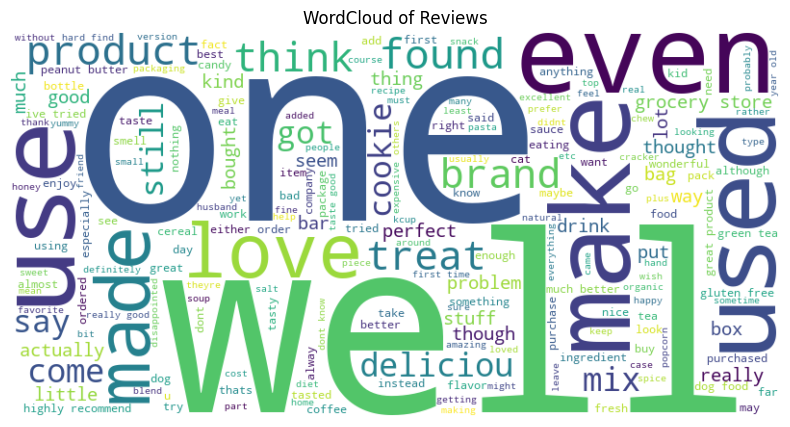

In [18]:
import matplotlib.pyplot as plt

text_for_cloud = (
    df.select("cleaned_text")
    .sample(False, 0.5)
    .toPandas()["cleaned_text"]
    .str.cat(sep=" ")
)

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    text_for_cloud
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Reviews")
plt.show()


In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
model = pipeline.fit(df)
data_tfidf = model.transform(df)

kmeans = KMeans(k=2, seed=42, featuresCol="features")
kmodel = kmeans.fit(data_tfidf)
df = kmodel.transform(data_tfidf)


25/04/19 13:39:36 WARN StopWordsRemover: Default locale set was [en_UA]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [31]:
df.head(5)

[Row(Score='5', Text='"Product received is as advertised.<br /><br /><a href=""http://www.amazon.com/gp/product/B001GVISJM"">Twizzlers', cleaned_text='product received advertisedbr br hrefhttpwwwamazoncomgpproductbgvisjmtwizzlers', words=['product', 'received', 'advertisedbr', 'br', 'hrefhttpwwwamazoncomgpproductbgvisjmtwizzlers'], filtered=['product', 'received', 'advertisedbr', 'br', 'hrefhttpwwwamazoncomgpproductbgvisjmtwizzlers'], rawFeatures=SparseVector(1000, {4: 1.0, 55: 1.0, 290: 1.0, 447: 1.0, 601: 1.0}), features=SparseVector(1000, {4: 4.1019, 55: 1.507, 290: 4.3841, 447: 1.466, 601: 3.1754}), prediction=0),
 Row(Score='5', Text="The BEST investment I've ever made for ginger. It's unbelievable! It's fibrous like the real ginger, has that spicy kick to it, but it's perfect with the sugar - calms it down.  It's very worth the $40 for 5lbs of it!  I'll be getting more soon - I use these as a topper for my ginger cupcakes and cookies :)", cleaned_text='best investment ive ever ma

In [32]:
df.groupBy("prediction").count().orderBy("count", ascending=False).show()

+----------+------+
|prediction| count|
+----------+------+
|         0|342377|
|         1| 50745|
+----------+------+



In [34]:
from pyspark.sql.functions import when

df = df.withColumn("label", when(df["Score"] <= 3, 0).otherwise(1))
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|305403|
|    0| 87719|
+-----+------+



# Conclusion: Spark vs. Pandas for EDA and Text Preprocessing

When comparing PySpark to the default pandas/NLTK approach for exploratory data analysis (EDA) and text preprocessing, Spark consistently performs better on larger datasets.

**Performance and Speed**

- Data loading is faster with Spark due to its distributed execution engine.
- GroupBy and aggregation operations scale better in Spark and run faster on large data.
- Text preprocessing using pandas and NLTK is slower, especially when cleaning or tokenizing text at scale. PySpark handles this more efficiently with UDFs and parallelism. (>10x Speed-up)
- TF-IDF vectorization and clustering with Spark MLlib is optimized for large-scale processing and performs better with high-dimensional text data.

**Summary**

- Use pandas and NLTK for small to medium datasets, quick experiments, and when simplicity matters.
- Use PySpark when working with large datasets, when performance becomes a concern, or when building scalable pipelines.
- Spark is more suitable for preprocessing data before feeding it into deep learning models like BERT.